In [200]:
import batoid
import danish
import numpy as np
import yaml
from scipy.optimize import root_scalar, least_squares
import asdf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib widget

In [2]:
# Let's find the footprint of L1 for a specific field angle

In [3]:
telescope = batoid.Optic.fromYaml("LSST_r.yaml")
wavelength=622e-9

In [4]:
def center_resid(x, thx, optic):
    z = telescope.stopSurface.surface.sag(x, 0) + telescope.stopSurface.coordSys.origin[2]
    vx, vy, vz = batoid.utils.gnomonicToDirCos(np.deg2rad(thx), 0.0)
    ray = batoid.RayVector(x, 0, z, vx, vy, vz, wavelength=wavelength)
    tf = telescope.traceFull(ray)
    x = tf[optic]['out'].x[0]
    return x

In [28]:
def circle_resid(r, az, cx, thx, optic, target):
    x = np.cos(az)*r+cx
    y = np.sin(az)*r
    z = telescope.stopSurface.surface.sag(x, y) + telescope.stopSurface.coordSys.origin[2]
    vx, vy, vz = batoid.utils.gnomonicToDirCos(np.deg2rad(thx), 0.0)
    ray = batoid.RayVector(x, y, z, vx, vy, vz, wavelength=wavelength)
    tf = telescope.traceFull(ray)
    x = tf[optic]['out'].x[0]
    y = tf[optic]['out'].y[0]
    return np.sqrt(x**2+y**2) - target

In [209]:
def contour(thx, name, attr, do_center=False):
    # First determine pupil position that passes through center of target optic
    if do_center:
        cx = root_scalar(
            center_resid,
            x0=-4, x1=0,
            args=(thx, name)
        ).root
    else:
        cx = -1
        
    rs = []
    azs = np.linspace(-np.pi, np.pi, 2*3*5*7, endpoint=False)
    for az in azs:
        args = (az, cx, thx, name, getattr(telescope[name].obscuration.original, attr))
        f0 = circle_resid(0.0, *args)
        f1 = circle_resid(6.5, *args)
        if f0*f1 > 0:
            rs.append(np.nan)
        else:
            rs.append(
                root_scalar(
                    circle_resid, 
                    x0=0, 
                    x1=6.5, 
                    args=args
                ).root
            )
    xs = [r*np.cos(az)+cx for r, az in zip(rs, azs)]
    ys = [r*np.sin(az) for r, az in zip(rs, azs)]
    return xs, ys

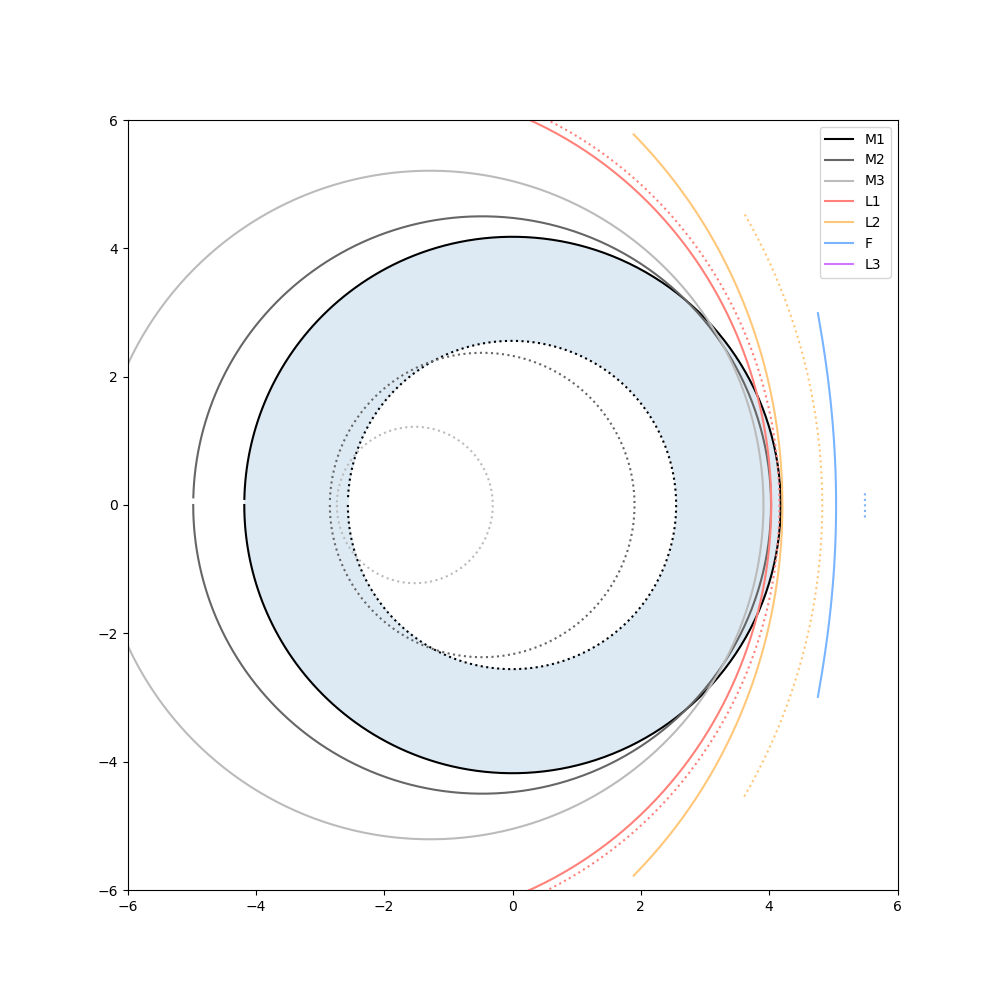

In [348]:
thx = 1.62
plt.figure(figsize=(10, 10))
plt.plot(*contour(thx, 'M1', 'outer'), c='#000000', label='M1')
plt.plot(*contour(thx, 'M1', 'inner', do_center=True), c='#000000', ls=':')
plt.plot(*contour(thx, 'M2', 'outer'), c='#666666', label='M2')
plt.plot(*contour(thx, 'M2', 'inner', do_center=True), c='#666666', ls=':')
plt.plot(*contour(thx, 'M3', 'outer'), c='#BBBBBB', label='M3')
plt.plot(*contour(thx, 'M3', 'inner', do_center=True), c='#BBBBBB', ls=':')
plt.plot(*contour(thx, 'L1_entrance', 'radius'), c='#Ff8179', label='L1')
plt.plot(*contour(thx, 'L1_exit', 'radius'), c='#Ff8179', ls=':')
plt.plot(*contour(thx, 'L2_entrance', 'radius'), c='#Ffc779', label='L2')
plt.plot(*contour(thx, 'L2_exit', 'radius'), c='#Ffc779', ls=':')
plt.plot(*contour(thx, 'Filter_entrance', 'radius'), c='#79b4ff', label='F')
plt.plot(*contour(thx, 'Filter_exit', 'radius'), c='#79b4ff', ls=':')
plt.plot(*contour(thx, 'L3_entrance', 'radius'), c='#D079ff', label='L3')
plt.plot(*contour(thx, 'L3_exit', 'radius'), c='#D079ff', ls=':')
plt.gca().add_patch(patches.Annulus( (0,0), 4.18, 4.18*0.39, alpha=0.15))
plt.gca().set_aspect('equal')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.legend()
plt.show()

In [136]:
def circle_resid2(
    params, x, y):
    cx, r = params
    res = np.sqrt((np.array(x)-cx)**2 + np.array(y)**2)-r
    w = np.isfinite(res)
    return res[w]

In [137]:
for name, attr, doc in [
    ('M1', 'outer', False),
    ('M1', 'inner', False),
    ('M2', 'outer', False),
    ('M2', 'inner', False),
    ('M3', 'outer', False),
    ('M3', 'inner', True),
    ('L1_entrance', 'radius', False),
    ('L1_exit', 'radius', False),
    ('L2_entrance', 'radius', False),
    ('L2_exit', 'radius', False),    
    ('Filter_entrance', 'radius', False),
    ('Filter_exit', 'radius', False),    
    ('L3_entrance', 'radius', False),
    ('L3_exit', 'radius', False),    
]:
    print()
    print(name, attr)
    x, y = contour(thx, name, attr, do_center=doc)
    if not np.any(np.isfinite(x)):
        continue
    result = least_squares(circle_resid2, [-1, 5], args=(x, y)).x
    print(result)
    print(np.max(np.abs(circle_resid2(result, x, y)))/8.36*133)
    print(np.median(np.abs(circle_resid2(result, x, y)))/8.36*133)    


M1 outer
[3.18154367e-10 4.18000000e+00]
2.8260222445003986e-14
1.4130111222501993e-14

M1 inner
[-0.00862658  2.558     ]
3.532527805625498e-14
2.119516683375299e-14

M2 outer
[-0.52510448  4.50137792]
0.0466661487623643
0.02313710277717096

M2 inner
[-0.52494424  2.37350487]
0.022597870759286858
0.014206397659379609

M3 outer
[-1.45153954  5.2156468 ]
0.029032609863944746
0.008909985838457712

M3 inner
[-1.69299116  1.21605499]
0.03857256916817709
0.027200017671495533

L1_entrance radius
[-3.12531949  6.80328906]
0.11994946083535776
0.03682231615089333

L1_exit radius
[-3.13210282  6.9360076 ]
0.0873964328549662
0.028073302099559688

L2_entrance radius
[-4.98435908  8.5934249 ]
0.08738761752153935
0.02691903942369562

L2_exit radius
[-5.04548112  9.24960241]
0.024365431775280107
0.008495565620422498

Filter_entrance radius
[-13.28117017  16.25116889]
0.04447290057661071
0.019179492260544932

Filter_exit radius
[-12.8795261   16.19769003]
0.01460935212339688
0.00985841997689363

L3_e

In [ ]:
# Let's measure from thx=0 to thx=2.0 in steps of 0.01.  Can throw away bad data afterwards.
# Going to save:
# For each thx:
#   For each optic:
#     xs, ys
# Try asdf

In [237]:
out = dict()
thxs = np.linspace(0, 2.0, 201)
for name, attr, doc in [
    ('M1', 'outer', False),
    ('M1', 'inner', True),
    ('M2', 'outer', False),
    ('M2', 'inner', True),
    ('M3', 'outer', False),
    ('M3', 'inner', True),
    ('L1_entrance', 'radius', False),
    ('L1_exit', 'radius', False),
    ('L2_entrance', 'radius', False),
    ('L2_exit', 'radius', False),    
    ('Filter_entrance', 'radius', False),
    ('Filter_exit', 'radius', False),    
    ('L3_entrance', 'radius', False),
    ('L3_exit', 'radius', False),    
]:
    key = name+'_'+attr if attr != 'radius' else name
    out[key] = dict()
    results = []
    for thx in tqdm(thxs):
        x, y = contour(thx, name, attr, do_center=doc)
        out[key][thx] = np.array(x), np.array(y)
    af = asdf.AsdfFile(out)
    af.write_to('rubin_vignetting_model.asdf')

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

In [346]:
# Produce new model.
fits = dict()
for name in names:
    radii = []
    centers = []
    for thx in thxs:
        x, y = out[name][thx]
        r = np.hypot(x, y)
        w = (r < 4.3) & (r > 2.3) & np.isfinite(r) 
        if np.sum(w) < 3:
            radius = np.nan
            center = np.nan
        else:
            center, radius = least_squares(circle_resid2, [-1, 5], args=(x[w], y[w])).x
        centers.append(center)
        radii.append(radius)
    centers = np.array(centers)
    radii = np.array(radii)
        
    # Fit a 3rd order polynomial
    w = np.isfinite(centers)
    pcenter = np.polyfit(thxs[w], centers[w], 3)
    center_fit = np.polyval(pcenter, thxs)
    center_fit[~w] = np.nan
    
    pradius = np.polyfit(thxs[w], radii[w], 3)
    radius_fit = np.polyval(pradius, thxs)
    radius_fit[~w] = np.nan

    fits[name] = dict(
        thx_min = float(max(np.min(thxs[w])-0.01, 0)),
        pcenter = pcenter.tolist(),
        pradius = pradius.tolist()
    )
    
    # fig, axes = plt.subplots(ncols=2, figsize=(6, 3))
    # axes[0].plot(thxs, centers, c='b')
    # axes[0].plot(thxs, center_fit, c='m', lw=0.5)
    # axes[1].plot(thxs, radii)
    # axes[1].plot(thxs, radius_fit, c='m', lw=0.5)
    # axes[0].set_ylabel("center (m)")
    # axes[1].set_ylabel("radius (m)")    
    # for ax in axes:
    #     ax.set_xlabel("th (deg)")
    # fig.suptitle(name)
    # fig.tight_layout()
    # plt.show()